# Setting

## Libraries

In [1]:
library(quantmod)
library(forecast)
library(rugarch)

Loading required package: xts

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Loading required package: TTR

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

Loading required package: parallel


Attaching package: ‘rugarch’


The following object is masked from ‘package:stats’:

    sigma




In [2]:
source("~/works/utils/r/myutils.r")
source("~/works/utils/r/myarimagarch.r")

## Data

In [3]:
train_start <- '1991-01-01'
train_end <- '2019-12-31'

test_start <- '2020-01-01'
test_end <- '2020-12-31'

lookahead <- 1

In [4]:
from <- train_start
to <- test_end
getSymbols("^GSPC", from=from, to=to)

[1] "^GSPC"

In [5]:
spx <- GSPC
colnames(spx) <- c('o','h','l','c','v','a')

In [6]:
# daily log. return
spx.ret <- diff(log(spx$a), lookahead)
colnames(spx.ret) <- 'logret'

In [7]:
train <- window(spx.ret, end=as.Date(train_end))
test <- window(spx.ret, start=as.Date(test_start), end=as.Date(test_end))

## CV Settings

In [8]:
YEAR <- 252
hori <- 21
peri <- floor(hori/2)
#wind <- 5*YEAR
wind <- 7*YEAR

testing

In [9]:
train_start <- '1991-01-01'
#train_end <- '2000-12-31'
train_end <- '1998-12-31'
train <- window(spx.ret, start=as.Date(train_start), end=as.Date(train_end))

In [10]:
n <- (nrow(train) - wind - hori)/floor(peri)
print(paste('number of iterations: ', round(n), sep=''))

[1] "number of iterations: 24"


## Regressors

In [11]:
x <- RSI(spx$a)
trainx <- merge(train, x, join='left', fill=NA)

In [12]:
# use close instead of adjusted to make consistent with "un-adjusted" high & low
x <- BBands(spx[,c('h','l','c')])
x <- x$pctB
trainx <- merge(trainx, x, join='left', fill=NA)

In [13]:
x <- MACD(spx$a)
x <- x$macd - x$signal
trainx <- merge(trainx, x, join='left', fill=NA)

In [14]:
colnames(trainx) <- c('y','rsi','bbands','macd')
trainx <- na.omit(trainx)
head(trainx)
tail(trainx)

                       y      rsi    bbands        macd
1991-02-19  0.0008938101 72.59254 0.8419486 -0.03641515
1991-02-20 -0.0115721543 66.25313 0.7706927 -0.18551057
1991-02-21 -0.0004657216 66.00481 0.7330987 -0.30953562
1991-02-22  0.0018614141 66.54491 0.7402938 -0.39546732
1991-02-25  0.0043934960 67.84742 0.7305630 -0.43573971
1991-02-26 -0.0121907956 60.80133 0.6379610 -0.55105032

                       y      rsi    bbands      macd
1998-12-23  0.0205344089 69.31506 1.1362226 0.1801475
1998-12-24 -0.0018494463 68.33272 1.0891085 0.2591878
1998-12-28 -0.0006363021 67.97622 0.9989878 0.2764233
1998-12-29  0.0132292844 71.34467 1.0004403 0.3444776
1998-12-30 -0.0079879511 66.76606 0.9423269 0.3006200
1998-12-31 -0.0021941483 65.52839 0.8488094 0.2269923

# Prophet

## Setting

In [15]:
library(prophet)
library(dplyr)

Loading required package: Rcpp

Loading required package: rlang


Attaching package: ‘dplyr’


The following objects are masked from ‘package:xts’:

    first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [16]:
cv.forecast <- function(x, h, xreg=NULL, xreg.msize=NULL) {
    
    check.ds <- function(x) {
        d <- try(as.POSIXct(x$ds, format = "%Y-%m-%d"), silent=T)
        if ((sum(is.na(d))>0) | (is.element("try-error", class(d))))  {
            #print("That wasn't correct!")
            x$ds <- seq(as.Date('1901-01-01'), length.out=length(x$ds), by=1)
        }
        return(x)
    }
    
    model <- prophet()

    if (!is.null(xreg)) {
        ### convert data for prophet
        #x <- ifelse(is.null(dim(x)), data.frame(x), x) # not works
        if (is.null(dim(x))) {x <- data.frame(x)}
        colnames(x) <- 'y'
        x.train <- cbind(x, xreg)
        x.train <- as.data.frame(x.train)
        x.train <- cbind(ds=rownames(x.train), x.train)
        rownames(x.train) <- NULL
        x.train <- check.ds(x.train)

        ### add regressors before fitting
        for (c in colnames(xreg)) {
            model <- add_regressor(model, c)
        }

        ### fit: must run after add_regressor and before make_future_dataframe
        model <- fit.prophet(model, x.train)

        ### prepare future ds
        future <- make_future_dataframe(model, periods=h)

        # regessor assumption for future
        if (is.null(xreg.msize)) {
            xreg.m <- xreg # calc mean for future with all the xreg
        } else {
            # calc mean for future with xreg of length xreg.mszie
            xreg.m <- tail(xreg, n=xreg.msize)
        }
        
        if (is.null(dim(xreg))) {
            xreg.h <- mean(xreg.m)
        } else {
            xreg.h <- colMeans(xreg.m)  
        }

        # rbind history & future of xreg
        xreg.all <- data.frame(xreg)
        xreg.coln <- colnames(xreg.all) # save name for the case of single xreg

        xreg.h <- data.frame(xreg.h)
        colnames(xreg.h) <- colnames(NA)
        xreg.h <- t(xreg.h)
        xreg.h <- as.ts(xreg.h[rep(seq_len(nrow(xreg.h)), h), ])
        xreg.h <- data.frame(xreg.h) # convert to frame for the case of single xreg

        # update future
        colnames(xreg.h) <- xreg.coln # match name to rbind
        xreg.all <- rbind(xreg.all, xreg.h)
        xreg.all$ds <- future$ds
        future <- xreg.all

    } else {
        x.train <- data.frame(ds=index(x), y=as.numeric(x))
        x.train <- check.ds(x.train)
        model <- fit.prophet(model, x.train)
        future <- make_future_dataframe(model, periods=h)
    }

    fc <- predict(model, future)
    fc <- list(method = "Prophet Forecasting", mean=tail(fc$yhat, h))
    return(fc)
} 


## Basic

In [17]:
result.m01.1 <- my.tsCV(train, cv.forecast, h=hori, window=wind, step=peri)

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.



[1] "12 % done."


Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.



[1] "23 % done."


Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.



[1] "35 % done."


Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.



[1] "46 % done."


Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.



[1] "58 % done."


Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.



[1] "69 % done."


Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.



[1] "81 % done."


Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.



[1] "92 % done."


Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.



In [18]:
x <- result.m01.1
from <- na.omit(x[,1])[1]
from <- index(train[from])
print(paste('cv starts from', from, sep=' '))

[1] "cv starts from 1997-12-31"


## Additional regressors

In [19]:
result.m01.2 <- my.tsCV(trainx[,1], cv.forecast, h=hori, window=wind, step=peri,
                       xreg=trainx[,2:4], silent=F)

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.



[1] "9 % done."


Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.



[1] "18 % done."


Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.



[1] "27 % done."


Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.



[1] "36 % done."


Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.



[1] "45 % done."


Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.



[1] "55 % done."


Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.



[1] "64 % done."


Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.



[1] "73 % done."


Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.



[1] "82 % done."


Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.



[1] "91 % done."


Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.



[1] "100 % done."


In [20]:
result.m01.3 <- my.tsCV(trainx[,1], cv.forecast, h=hori, window=wind, step=peri,
                       xreg=trainx[,3], silent=F)

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.



[1] "9 % done."


Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.



[1] "18 % done."


Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.



[1] "27 % done."


Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.



[1] "36 % done."


Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.



[1] "45 % done."


Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.



[1] "55 % done."


Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.



[1] "64 % done."


Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.



[1] "73 % done."


Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.



[1] "82 % done."


Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.



[1] "91 % done."


Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.



[1] "100 % done."


In [21]:
result.m01.4 <- my.tsCV(trainx[,1], cv.forecast, h=hori, window=wind, step=peri,
                       xreg=trainx[,2:4], xreg.msize=hori)

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.



[1] "9 % done."


Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.



[1] "18 % done."


Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.



[1] "27 % done."


Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.



[1] "36 % done."


Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.



[1] "45 % done."


Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.



[1] "55 % done."


Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.



[1] "64 % done."


Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.



[1] "73 % done."


Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.



[1] "82 % done."


Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.



[1] "91 % done."


Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.



[1] "100 % done."


## Compare Errors

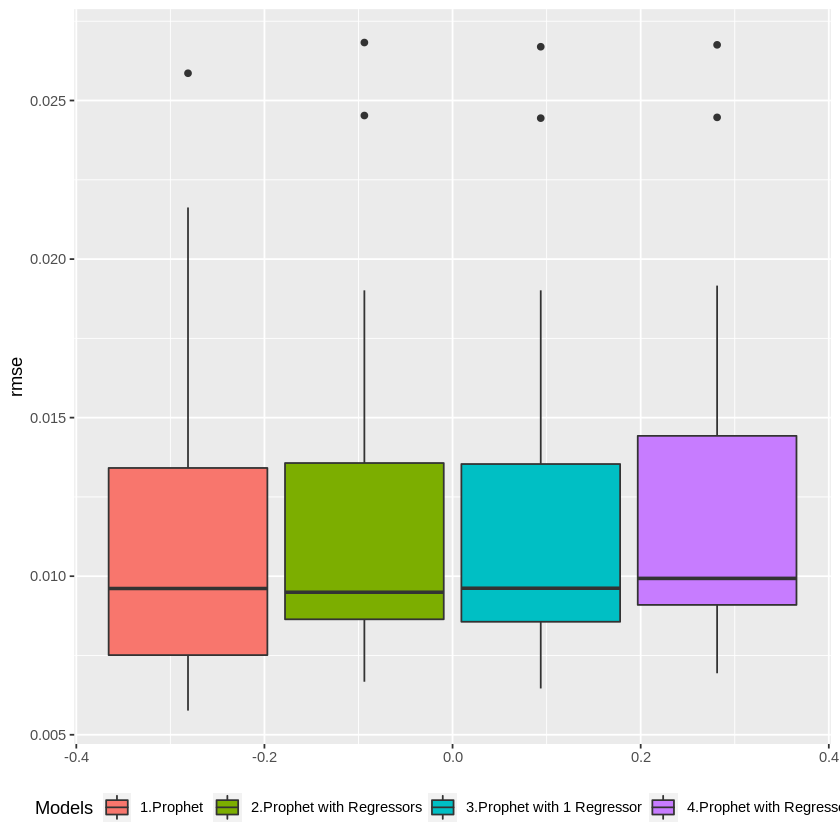

In [22]:
errors.1 <- my.get_result(result.m01.1, '1.Prophet')
errors.2 <- my.get_result(result.m01.2, '2.Prophet with Regressors')
errors.3 <- my.get_result(result.m01.3, '3.Prophet with 1 Regressor')
errors.4 <- my.get_result(result.m01.4, '4.Prophet with Regressor (2)')

x <- rbind(errors.1, errors.2)
x <- rbind(x, errors.3)
x <- rbind(x, errors.4)
my.plot_errors(x, metrics=c('rmse'))

In [51]:
result.m01 <- result.m01.2

# BSTS

## Setting

In [23]:
library(bsts)

Loading required package: BoomSpikeSlab

Loading required package: Boom

Loading required package: MASS


Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select



Attaching package: ‘Boom’


The following object is masked from ‘package:stats’:

    rWishart



Attaching package: ‘BoomSpikeSlab’


The following object is masked from ‘package:stats’:

    knots



Attaching package: ‘bsts’


The following object is masked from ‘package:BoomSpikeSlab’:

    SuggestBurn




In [24]:
cv.forecast <- function(x, h, xreg=NULL, xreg.msize=NULL, expected.model.size=NULL) {
    
    if (!is.null(xreg)) {
        ### convert data for bsts
        if (is.null(dim(x))) {x <- data.frame(x)}
        colnames(x) <- 'y'
        x.train <- cbind(x, xreg)
        x.train <- as.data.frame(x.train)
        
        ### fitting
        n <- ncol(x.train)
        if (is.null(expected.model.size)) {
            expected.model.size <- n
        } else if (expected.model.size > n) {
            expected.model.size <- n
        }
        ss <- AddSemilocalLinearTrend(list(), x.train$y)
        model <- bsts(y ~ .,
                      state.specification = ss,
                      niter = 1000,
                      data = x.train,
                      expected.model.size = expected.model.size)  # Passed to SpikeSlabPrior.
        
        ### prepare future of xreg for prediction
        # regessor assumption for future
        if (is.null(xreg.msize)) {
            xreg.m <- xreg # calc mean for future with all the xreg
        } else {
            # calc mean for future with xreg of length xreg.mszie
            xreg.m <- tail(xreg, n=xreg.msize)
        }

        if (is.null(dim(xreg))) {
            xreg.h <- mean(xreg.m)
        } else {
            xreg.h <- colMeans(xreg.m)  
        }

        xreg.all <- data.frame(xreg)
        xreg.coln <- colnames(xreg.all) # save name for the case of single xreg
        xreg.h <- data.frame(xreg.h)
        colnames(xreg.h) <- colnames(NA)
        xreg.h <- t(xreg.h)
        xreg.h <- as.ts(xreg.h[rep(seq_len(nrow(xreg.h)), h), ])
        xreg.h <- data.frame(xreg.h) # convert to frame for the case of single xreg
        colnames(xreg.h) <- xreg.coln # match name to rbind

    } else {
        ss <- AddSemilocalLinearTrend(list(), x)
        model <- bsts(x, state.specification = ss, niter=1000)
        xreg.h <- NULL
    }
    
    fc <- predict(model, horizon=h, newdata=xreg.h)
    return(fc)
} 

## Basic

In [25]:
result.m02.1 <- my.tsCV(train, cv.forecast, h=hori, window=wind, step=peri)

=-=-=-=-= Iteration 0 Thu Sep 15 18:23:03 2022 =-=-=-=-=
=-=-=-=-= Iteration 100 Thu Sep 15 18:23:05 2022 =-=-=-=-=
=-=-=-=-= Iteration 200 Thu Sep 15 18:23:08 2022 =-=-=-=-=
=-=-=-=-= Iteration 300 Thu Sep 15 18:23:10 2022 =-=-=-=-=
=-=-=-=-= Iteration 400 Thu Sep 15 18:23:12 2022 =-=-=-=-=
=-=-=-=-= Iteration 500 Thu Sep 15 18:23:14 2022 =-=-=-=-=
=-=-=-=-= Iteration 600 Thu Sep 15 18:23:17 2022 =-=-=-=-=
=-=-=-=-= Iteration 700 Thu Sep 15 18:23:19 2022 =-=-=-=-=
=-=-=-=-= Iteration 800 Thu Sep 15 18:23:21 2022 =-=-=-=-=
=-=-=-=-= Iteration 900 Thu Sep 15 18:23:23 2022 =-=-=-=-=
=-=-=-=-= Iteration 0 Thu Sep 15 18:23:26 2022 =-=-=-=-=
=-=-=-=-= Iteration 100 Thu Sep 15 18:23:28 2022 =-=-=-=-=
=-=-=-=-= Iteration 200 Thu Sep 15 18:23:30 2022 =-=-=-=-=
=-=-=-=-= Iteration 300 Thu Sep 15 18:23:32 2022 =-=-=-=-=
=-=-=-=-= Iteration 400 Thu Sep 15 18:23:34 2022 =-=-=-=-=
=-=-=-=-= Iteration 500 Thu Sep 15 18:23:37 2022 =-=-=-=-=
=-=-=-=-= Iteration 600 Thu Sep 15 18:23:39 2022 =-=-=-=-=
=

In [26]:
x <- result.m02.1
from <- na.omit(x[,1])[1]
from <- index(train[from])
print(paste('cv starts from', from, sep=' '))

[1] "cv starts from 1997-12-31"


## Regression with spike and slab priors

In [27]:
result.m02.2 <- my.tsCV(trainx[,1], cv.forecast, h=hori, window=wind, step=peri,
                       xreg=trainx[,2:4], silent=F)

=-=-=-=-= Iteration 0 Thu Sep 15 18:33:44 2022 =-=-=-=-=
=-=-=-=-= Iteration 100 Thu Sep 15 18:33:47 2022 =-=-=-=-=
=-=-=-=-= Iteration 200 Thu Sep 15 18:33:50 2022 =-=-=-=-=
=-=-=-=-= Iteration 300 Thu Sep 15 18:33:52 2022 =-=-=-=-=
=-=-=-=-= Iteration 400 Thu Sep 15 18:33:55 2022 =-=-=-=-=
=-=-=-=-= Iteration 500 Thu Sep 15 18:33:58 2022 =-=-=-=-=
=-=-=-=-= Iteration 600 Thu Sep 15 18:34:01 2022 =-=-=-=-=
=-=-=-=-= Iteration 700 Thu Sep 15 18:34:04 2022 =-=-=-=-=
=-=-=-=-= Iteration 800 Thu Sep 15 18:34:07 2022 =-=-=-=-=
=-=-=-=-= Iteration 900 Thu Sep 15 18:34:10 2022 =-=-=-=-=
=-=-=-=-= Iteration 0 Thu Sep 15 18:34:13 2022 =-=-=-=-=
=-=-=-=-= Iteration 100 Thu Sep 15 18:34:16 2022 =-=-=-=-=
=-=-=-=-= Iteration 200 Thu Sep 15 18:34:18 2022 =-=-=-=-=
=-=-=-=-= Iteration 300 Thu Sep 15 18:34:21 2022 =-=-=-=-=
=-=-=-=-= Iteration 400 Thu Sep 15 18:34:24 2022 =-=-=-=-=
=-=-=-=-= Iteration 500 Thu Sep 15 18:34:27 2022 =-=-=-=-=
=-=-=-=-= Iteration 600 Thu Sep 15 18:34:30 2022 =-=-=-=-=
=

## Compare Errors

In [28]:
my.figsize(10,6)

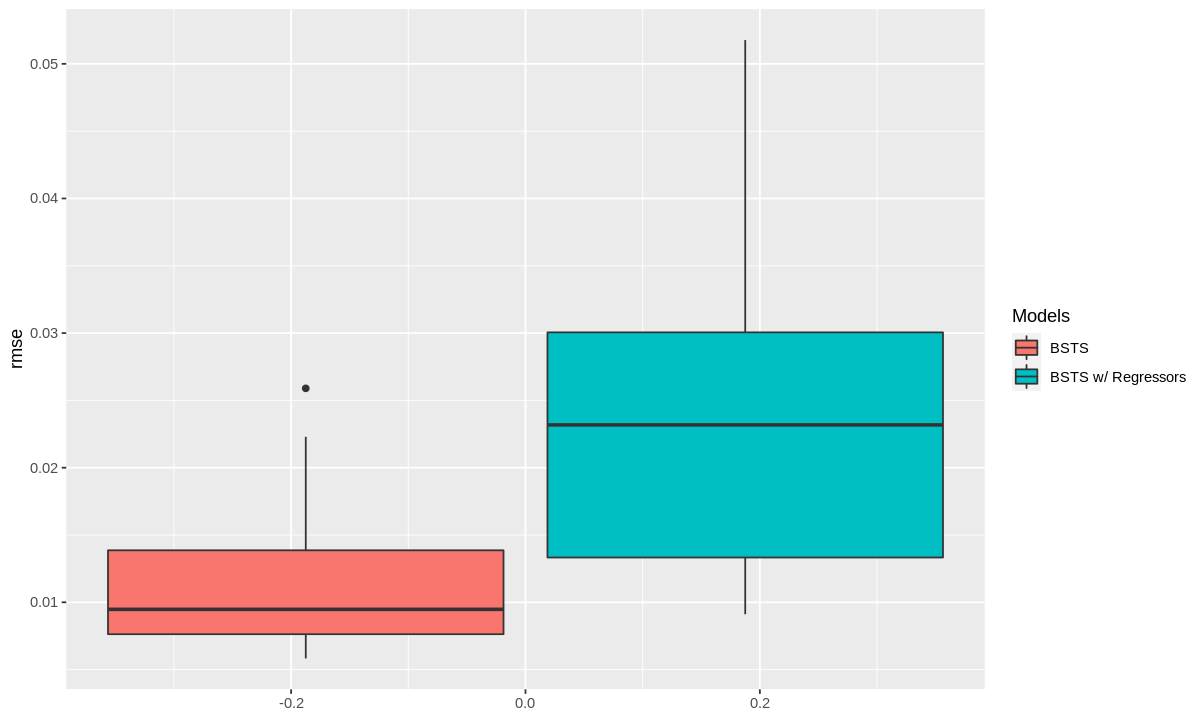

In [29]:
errors.1 <- my.get_result(result.m02.1, 'BSTS')
errors.2 <- my.get_result(result.m02.2, 'BSTS w/ Regressors')

x <- rbind(errors.1, errors.2)

my.plot_errors(x, metrics=c('rmse'), loc='right')

In [54]:
result.m02 <- result.m02.1

# ARIMA

In [30]:
cv.forecast <- function(x, h) {
    forecast(auto.arima(x, trace=TRUE, ic='aicc', seasonal=FALSE, 
                        #allowdrift=TRUE, allowmean = TRUE, # default
                        lambda="auto"), h=h)
}

In [31]:
result.m03 <- my.tsCV(train, cv.forecast, h=hori, window=wind, step=peri)


 Fitting models using approximations to speed things up...

 ARIMA(2,0,2) with non-zero mean : -12252.31
 ARIMA(0,0,0) with non-zero mean : -12248.37
 ARIMA(1,0,0) with non-zero mean : -12247.25
 ARIMA(0,0,1) with non-zero mean : -12246.81
 ARIMA(0,0,0) with zero mean     : 5005.842
 ARIMA(1,0,2) with non-zero mean : -12263.59
 ARIMA(0,0,2) with non-zero mean : -12245.56
 ARIMA(1,0,1) with non-zero mean : -12245.25
 ARIMA(1,0,3) with non-zero mean : -12261.66
 ARIMA(0,0,3) with non-zero mean : -12247.24
 ARIMA(2,0,1) with non-zero mean : -12251.02
 ARIMA(2,0,3) with non-zero mean : -12253.57
 ARIMA(1,0,2) with zero mean     : Inf

 Now re-fitting the best model(s) without approximations...

 ARIMA(1,0,2) with non-zero mean : -12248.74

 Best model: ARIMA(1,0,2) with non-zero mean 


 Fitting models using approximations to speed things up...

 ARIMA(2,0,2) with non-zero mean : -12263.54
 ARIMA(0,0,0) with non-zero mean : -12253.43
 ARIMA(1,0,0) with non-zero mean : -12253.68
 ARIMA(0,0

In [32]:
x <- result.m03
from <- na.omit(x[,1])[1]
from <- index(train[from])
print(paste('cv starts from', from, sep=' '))

[1] "cv starts from 1997-12-31"


# Regression with ARIMA errors

## Basic

In [33]:
cv.forecast <- function(x, h, xreg=NULL, xreg.msize=NULL) {
    
    if (!is.null(xreg)) {
        
        if (is.null(xreg.msize)) {
            xreg.m <- xreg # calc mean for future with all the xreg
        } else {
            # calc mean for future with xreg of length xreg.mszie
            xreg.m <- tail(xreg, n=xreg.msize)
        }
        
        if (is.null(dim(xreg))) {
            xreg.h <- mean(xreg.m)
        } else {
            xreg.h <- colMeans(xreg.m)  
        }
        
        xreg.h <- data.frame(xreg.h)
        colnames(xreg.h) <- colnames(NA)
        #colnames(xreg.h) <- colnames(xreg) # error with multiple xreg
        xreg.h <- t(xreg.h)
        xreg.h <- as.ts(xreg.h[rep(seq_len(nrow(xreg.h)), h), ])
        
    } else {
        xreg.h <- NULL
    }
    
    fc <- forecast(auto.arima(x, trace=TRUE, ic='aicc', seasonal=FALSE, 
                              xreg=xreg, 
                              #lambda="auto" # not for negative value
                              ), h=h, xreg=xreg.h)
    return(fc)
}

In [34]:
result.m04.1 <- my.tsCV(trainx[,1], cv.forecast, h=hori, window=wind, step=peri,
                      silent=F,
                      xreg=trainx[,2:4])


 Fitting models using approximations to speed things up...

 Regression with ARIMA(2,0,2) errors : -13090.73
 Regression with ARIMA(0,0,0) errors : -12481.33
 Regression with ARIMA(1,0,0) errors : -12481.38
 Regression with ARIMA(0,0,1) errors : -12480.83
 Regression with ARIMA(0,0,0) errors : -12381.52
 Regression with ARIMA(1,0,2) errors : -12482.89
 Regression with ARIMA(2,0,1) errors : -12481.71
 Regression with ARIMA(3,0,2) errors : -13113.99
 Regression with ARIMA(3,0,1) errors : Inf
 Regression with ARIMA(4,0,2) errors : -13085.22
 Regression with ARIMA(3,0,3) errors : -13121.87
 Regression with ARIMA(2,0,3) errors : Inf
 Regression with ARIMA(4,0,3) errors : -13113.33
 Regression with ARIMA(3,0,4) errors : -13121.99
 Regression with ARIMA(2,0,4) errors : -13095.36
 Regression with ARIMA(4,0,4) errors : -13124.65
 Regression with ARIMA(5,0,4) errors : -13115.73
 Regression with ARIMA(4,0,5) errors : -13124.6
 Regression with ARIMA(3,0,5) errors : -13123.9
 Regression with ARIMA

In [35]:
x <- result.m04.1
from <- na.omit(x[,1])[1]
from <- index(train[from])
print(paste('cv starts from', from, sep=' '))

[1] "cv starts from 1997-12-31"


## Normalize data

In [36]:
mins <- t(apply(trainx, 2, min))
maxs <- t(apply(trainx, 2, max))
print(data.frame(rbind(mins, maxs), row.names=c('min','max')))

              y      rsi     bbands       macd
min -0.07112747 18.08944 -0.3975811 -0.9335563
max  0.04988692 84.90071  1.3157451  1.0604552


In [37]:
cv.forecast.norm <- function(x, h, xreg=NULL, xreg.msize=NULL) {
    
    x <- my.minmaxscale(x)
    sc <- attr(x, 'scaled:center')
    ss <- attr(x, 'scaled:scale')
    
    if (!is.null(xreg)) {
        xreg <- my.minmaxscale(xreg)
        
        if (is.null(xreg.msize)) {
            xreg.m <- xreg # calc mean for future with all the xreg
        } else {
            # calc mean for future with xreg of length xreg.mszie
            xreg.m <- tail(xreg, n=xreg.msize)
        }
        
        if (is.null(dim(xreg))) {
            xreg.h <- mean(xreg.m)
        } else {
            xreg.h <- colMeans(xreg.m)  
        }
        
        xreg.h <- data.frame(xreg.h)
        colnames(xreg.h) <- colnames(NA)
        #colnames(xreg.h) <- colnames(xreg) # error with multiple xreg
        xreg.h <- t(xreg.h)
        xreg.h <- as.ts(xreg.h[rep(seq_len(nrow(xreg.h)), h), ])
        
    } else {
        xreg.h <- NULL
    }
    
    fc <- forecast(auto.arima(x, trace=TRUE, ic='aicc', seasonal=FALSE, 
                              xreg=xreg, 
                              #lambda="auto" # not for negative value
                              ), h=h, xreg=xreg.h)
    fc.m <- my.minmaxscale(fc$mean, sc, ss)
    fc <- list(method=fc$method, mean=fc.m)
    return(fc)
}

In [38]:
result.m04.2 <- my.tsCV(trainx[,1], cv.forecast.norm, h=hori, window=wind, step=peri,
                      silent=F,
                      xreg=trainx[,2:4])


 Fitting models using approximations to speed things up...

 Regression with ARIMA(2,0,2) errors : -3194.691
 Regression with ARIMA(0,0,0) errors : -2585.311
 Regression with ARIMA(1,0,0) errors : -2585.367
 Regression with ARIMA(0,0,1) errors : -2584.812
 Regression with ARIMA(0,0,0) errors : -2587.322
 Regression with ARIMA(1,0,2) errors : -2586.88
 Regression with ARIMA(2,0,1) errors : -2585.699
 Regression with ARIMA(3,0,2) errors : -3217.866
 Regression with ARIMA(3,0,1) errors : -2582.431
 Regression with ARIMA(4,0,2) errors : -3189.202
 Regression with ARIMA(3,0,3) errors : -3228.402
 Regression with ARIMA(2,0,3) errors : -3195.144
 Regression with ARIMA(4,0,3) errors : -3221.289
 Regression with ARIMA(3,0,4) errors : -3227.064
 Regression with ARIMA(2,0,4) errors : -3199.34
 Regression with ARIMA(4,0,4) errors : -3228.633
 Regression with ARIMA(5,0,4) errors : -3219.718
 Regression with ARIMA(4,0,5) errors : -3228.581
 Regression with ARIMA(3,0,5) errors : -3227.553
 Regressio

In [39]:
x <- result.m04.2
from <- na.omit(x[,1])[1]
from <- index(train[from])
print(paste('cv starts from', from, sep=' '))

[1] "cv starts from 1997-12-31"


In [31]:
# temp saving
#write.csv(result.m02, file="result.m02.csv")

## Regressor mean of smaller period for forecast 
- Regressor mean for forecast is calculated from the number of latest 'horizon' period
- the 1st model used the number of latest 'window' period for the calc of regressor mean

In [40]:
result.m04.3 <- my.tsCV(trainx[,1], cv.forecast, h=hori, window=wind, step=peri,
                      xreg.msize=hori,
                      xreg=trainx[,2:4])


 Fitting models using approximations to speed things up...

 Regression with ARIMA(2,0,2) errors : -13090.73
 Regression with ARIMA(0,0,0) errors : -12481.33
 Regression with ARIMA(1,0,0) errors : -12481.38
 Regression with ARIMA(0,0,1) errors : -12480.83
 Regression with ARIMA(0,0,0) errors : -12381.52
 Regression with ARIMA(1,0,2) errors : -12482.89
 Regression with ARIMA(2,0,1) errors : -12481.71
 Regression with ARIMA(3,0,2) errors : -13113.99
 Regression with ARIMA(3,0,1) errors : Inf
 Regression with ARIMA(4,0,2) errors : -13085.22
 Regression with ARIMA(3,0,3) errors : -13121.87
 Regression with ARIMA(2,0,3) errors : Inf
 Regression with ARIMA(4,0,3) errors : -13113.33
 Regression with ARIMA(3,0,4) errors : -13121.99
 Regression with ARIMA(2,0,4) errors : -13095.36
 Regression with ARIMA(4,0,4) errors : -13124.65
 Regression with ARIMA(5,0,4) errors : -13115.73
 Regression with ARIMA(4,0,5) errors : -13124.6
 Regression with ARIMA(3,0,5) errors : -13123.9
 Regression with ARIMA

In [41]:
x <- result.m04.3
from <- na.omit(x[,1])[1]
from <- index(train[from])
print(paste('cv starts from', from, sep=' '))

[1] "cv starts from 1997-12-31"


## Compare Errors

In [42]:
my.figsize(10,6)

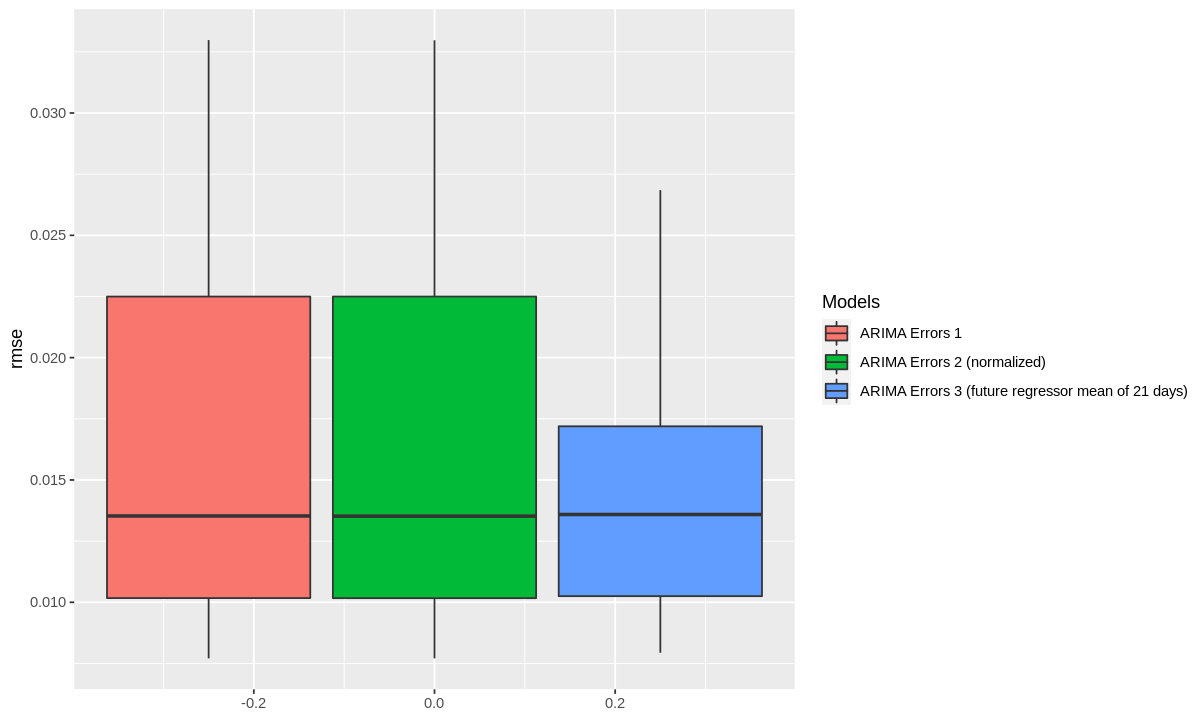

In [43]:
errors.1 <- my.get_result(result.m04.1, 'ARIMA Errors 1')
errors.2 <- my.get_result(result.m04.2, 'ARIMA Errors 2 (normalized)')
n <- paste('ARIMA Errors 3 (future regressor mean of', hori ,'days)', sep=' ')
errors.3 <- my.get_result(result.m04.3, n)

x <- rbind(errors.1, errors.2)
x <- rbind(x, errors.3)

my.plot_errors(x, metrics=c('rmse'), loc='right')

In [52]:
result.m04 <- result.m04.3
#errors.m03 <- errors.m03.3

# ARIMA+GARCH

In [44]:
cv.forecast <- function(x, h) {
    forc <- ag2.forecast(x, h, out.sample=0)
    if (!is.na(forc)) {
        fc <- list(method = "ARIMA+GARCH Forecasting", mean=forc@forecast$seriesFor[,1])
        attr(fc$mean, "names") <- NULL
        return(fc)
    }
}

In [45]:
result.m05 <- my.tsCV(train, cv.forecast, h=hori, window=wind, step=peri)

[1] "12 % done."
[1] "23 % done."
[1] "35 % done."
[1] "46 % done."
[1] "58 % done."
[1] "69 % done."
[1] "81 % done."
[1] "92 % done."


In [46]:
x <- result.m05
from <- na.omit(x[,1])[1]
from <- index(train[from])
print(paste('cv starts from', from, sep=' '))

[1] "cv starts from 1997-12-31"


# Model Comparision

In [55]:
errors.1 <- my.get_result(result.m01, '1. Prophet')
errors.2 <- my.get_result(result.m02, '2. BSTS')
errors.3 <- my.get_result(result.m03, '3. ARIMA')
errors.4 <- my.get_result(result.m04, '4. ARIMA Errors')
errors.5 <- my.get_result(result.m05, '5. ARIMA+GARCH')

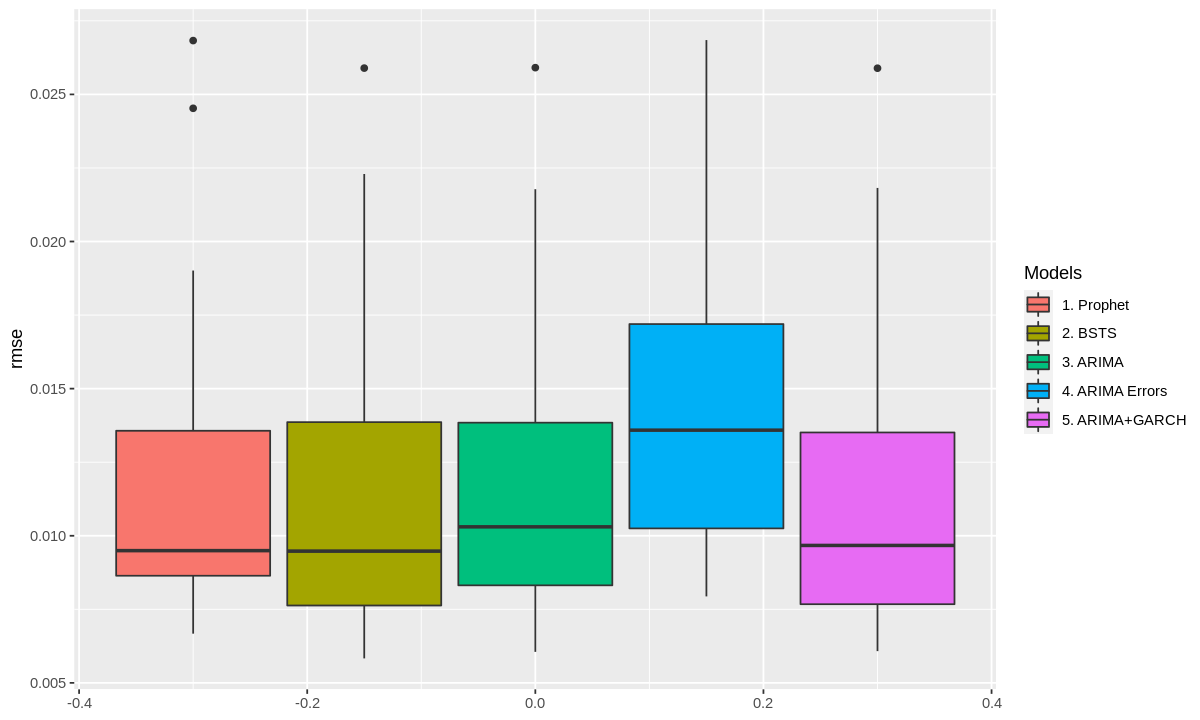

In [94]:
errors.list <- list(errors.1, errors.2, errors.3, errors.4, errors.5)
x <- errors.list[[1]]
for (e in errors.list[2:length(errors.list)]) {
    x <- rbind(x, e)
}

my.figsize(10, 6)
my.plot_errors(x, metrics=c('rmse'), loc='right')